In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from data_prep import Password as P

In [2]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [3]:
class Discriminator(nn.Module):
    def __init__(self, hidden_size):
        super(Discriminator, self).__init__()

        self.input_size = P.n_letters
        self.hidden_size = hidden_size
        self.output_size = 2
        
        self.i2h = nn.Linear(self.input_size + self.hidden_size, self.hidden_size)
        self.i2o = nn.Linear(self.input_size + self.hidden_size, self.output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [4]:
class Generator(nn.Module):
    def __init__(self, hidden_size):
        super(Generator, self).__init__()
        
        self.input_size = P.n_letters
        self.hidden_size = hidden_size
        self.output_size = P.n_letters
        
        self.lstm = nn.LSTM(self.input_size, self.hidden_size)
        self.h2o = nn.Linear(self.hidden_size, self.output_size)
        self.dropout = nn.Dropout(0.1)
        self.hidden = self.initHiddenZeros()

    def forward(self, input):
        output, self.hidden = self.lstm(input.view(1,1,-1), self.hidden)
        output = self.h2o(output)
        output = self.dropout(output)
        output = F.log_softmax(output,dim=2)
        return output

    def initHiddenZeros(self):
        return (torch.zeros(1, 1, self.hidden_size),
                torch.zeros(1, 1, self.hidden_size))
    
    def initHiddenRand(self):
        return (torch.rand(1,1, self.hidden_size), 
                torch.rand(1,1, self.hidden_size))
    
    def generate_N(self, n_generate = 100, max_length = 18):
        generate_list = []

        for i in range(n_generate):
            start_letter = passwords.passwords_string[random.randint(0,len(passwords.passwords_string) - 1)][0]
            with torch.no_grad():
                input_tensor = P.passwordToInputTensor(start_letter)
                gen.hidden = gen.initHiddenRand()

                output_password = start_letter

                for c in range(max_length):
                    output = gen(input_tensor[0])
                    output = output.view(1,-1)
                    topv, topi = output.topk(1)
                    topi = topi[0][0]
                    if topi == P.n_letters - 1:
                        break
                    else:
                        letter = P.all_letters[topi]
                        output_password += letter
                    input_tensor = P.passwordToInputTensor(letter)

            generate_list.append(output_password)

In [5]:
def pre_train_gen(input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    gen.hidden = gen.initHiddenZeros()
    
    criterion = nn.NLLLoss()
    optimizer = torch.optim.SGD(gen.parameters(), lr=0.1)
    
    gen.zero_grad()
    loss = torch.tensor(0, dtype = torch.float32, requires_grad = True)

    for i in range(input_line_tensor.size(0)):
        output = gen(input_line_tensor[i])
        output = output.view(1,-1)
        l = criterion(output, target_line_tensor[i])
        loss = loss + l
    
    loss.backward()
    optimizer.step()
    
    return output, loss.item() / input_line_tensor.size(0)

In [6]:
gen = Generator(128)

In [7]:
passwords = P()

INFO:root:Initializing passwords...
DEBUG:root:Loading from existing json file...
INFO:root:Done initializing passwords.


In [8]:
pre_train_iters = 50000
print_every = 1000
loss_trend = []

In [ ]:
logging.info("---------- Pre-training generator ----------")
for i in range(pre_train_iters):
    input_tensor = P.passwordToInputTensor(passwords.passwords_string[i])
    target_tensor = P.passwordToTargetTensor(passwords.passwords_string[i])
    output, loss = pre_train_gen(input_tensor, target_tensor)
    
    
    if i % print_every == 0:
        logging.debug("Iter: "+ str(i)+" Loss: "+str(loss))
        loss_trend.append(loss)

INFO:root:---------- Pre-training generator ----------
DEBUG:root:Iter: 0 Loss: 4.419293403625488
DEBUG:root:Iter: 1000 Loss: 2.8837265968322754
DEBUG:root:Iter: 2000 Loss: 2.920161008834839
DEBUG:root:Iter: 3000 Loss: 2.143282890319824
DEBUG:root:Iter: 4000 Loss: 2.3327865600585938
DEBUG:root:Iter: 5000 Loss: 2.1798338890075684
DEBUG:root:Iter: 6000 Loss: 2.5434815883636475
DEBUG:root:Iter: 7000 Loss: 3.1647872924804688


DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


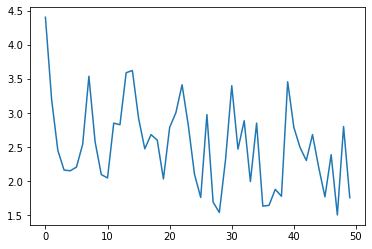

In [31]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

logger.setLevel(logging.INFO)

plt.figure()
plt.plot(loss_trend)
#plt.savefig('pictures/rnn-rnn-loss.png',dpi=400)
plt.show()

In [27]:
import random

max_length = 18
n_generate = 100
generate_list = []

for i in range(n_generate):
    start_letter = P.all_letters[random.randint(0,P.n_letters - 2)]
    with torch.no_grad():
        input_tensor = P.passwordToInputTensor(start_letter)
        gen.hidden = gen.initHiddenRand()
        
        output_password = start_letter
        
        for c in range(max_length):
            output = gen(input_tensor[0])
            output = output.view(1,-1)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == P.n_letters - 1:
                break
            else:
                letter = P.all_letters[topi]
                output_password += letter
            input_tensor = P.passwordToInputTensor(letter)
        
    generate_list.append(output_password)

In [20]:
import random
gen.generate_N()

tensor([[0.1000, 0.2000, 0.3000]])

In [21]:
c = nn.NLLLoss()
a = torch.tensor([.1, .2, .3]).unsqueeze_(0)
b = torch.tensor([2])
a, b
c(a,b)

tensor(-0.3000)

In [5]:
m = nn.LogSoftmax(dim=1)
loss = nn.NLLLoss()
# input is of size N x C = 3 x 5
input = torch.randn(3, 5, requires_grad=True)
# each element in target has to have 0 <= value < C
target = torch.tensor([1, 0, 4])
output = loss(m(input), target)

In [6]:
output

tensor(3.3456, grad_fn=<NllLossBackward>)

In [7]:
a = torch.tensor(1, dtype = torch.float32, requires_grad = True)
a.backward()

In [8]:
m(input)

tensor([[-2.0510, -2.8383, -1.0413, -1.8873, -1.1764],
        [-2.6391, -0.5184, -1.9736, -3.1967, -1.8758],
        [-1.8602, -2.0071, -0.4392, -2.9012, -4.5594]],
       grad_fn=<LogSoftmaxBackward>)

In [9]:
input

tensor([[-0.0663, -0.8536,  0.9434,  0.0974,  0.8083],
        [-0.7525,  1.3682, -0.0870, -1.3101,  0.0107],
        [ 0.2476,  0.1007,  1.6686, -0.7934, -2.4516]], requires_grad=True)

In [34]:
out = gen(P.passwordToInputTensor('a'))
out

tensor([[[ -5.0843,  -5.8548,  -5.1563,  -3.5716,  -6.0439,  -6.7771,  -4.8770,
           -3.8182,  -4.9750,  -5.9978,  -5.9844,  -3.4894,  -3.9110,  -2.4244,
           -5.1430,  -6.1603,  -7.5964,  -3.7123,  -4.7965,  -4.4238,  -5.8014,
           -5.9194,  -6.2230,  -4.7965,  -5.8825,  -6.2293, -11.7699, -11.3611,
          -11.7875, -10.5960, -11.7685, -10.8793, -11.1059, -11.3253,  -4.7965,
          -10.8527, -11.4240, -11.0469, -11.1861, -11.0400, -11.4240, -11.3294,
          -10.6533, -11.6024, -10.9606, -11.3027, -11.2317, -11.4250, -11.0400,
          -11.0968, -10.9664, -10.6589,  -4.9287,  -2.8658,  -4.5508,  -6.2007,
           -7.0480,  -6.4858,  -6.7830,  -5.9993,  -7.2981,  -6.8640,  -8.3837,
          -10.7644,  -4.7965, -10.4315, -10.4323, -10.8277, -10.9078, -10.4456,
           -9.7014, -10.9131,  -7.1762,  -4.7965,  -9.6006, -10.5296, -10.7478,
          -10.8691, -10.4874,  -0.5308]]], grad_fn=<LogSoftmaxBackward>)

In [39]:
out.view(1,-1)

tensor([[ -5.0843,  -5.8548,  -5.1563,  -3.5716,  -6.0439,  -6.7771,  -4.8770,
          -3.8182,  -4.9750,  -5.9978,  -5.9844,  -3.4894,  -3.9110,  -2.4244,
          -5.1430,  -6.1603,  -7.5964,  -3.7123,  -4.7965,  -4.4238,  -5.8014,
          -5.9194,  -6.2230,  -4.7965,  -5.8825,  -6.2293, -11.7699, -11.3611,
         -11.7875, -10.5960, -11.7685, -10.8793, -11.1059, -11.3253,  -4.7965,
         -10.8527, -11.4240, -11.0469, -11.1861, -11.0400, -11.4240, -11.3294,
         -10.6533, -11.6024, -10.9606, -11.3027, -11.2317, -11.4250, -11.0400,
         -11.0968, -10.9664, -10.6589,  -4.9287,  -2.8658,  -4.5508,  -6.2007,
          -7.0480,  -6.4858,  -6.7830,  -5.9993,  -7.2981,  -6.8640,  -8.3837,
         -10.7644,  -4.7965, -10.4315, -10.4323, -10.8277, -10.9078, -10.4456,
          -9.7014, -10.9131,  -7.1762,  -4.7965,  -9.6006, -10.5296, -10.7478,
         -10.8691, -10.4874,  -0.5308]], grad_fn=<ViewBackward>)

In [2]:
import torch
a = torch.tensor([[[[1],[2],[3]]]])
a

tensor([[[[1],
          [2],
          [3]]]])

In [3]:
aa = a.view(1, 1, 1, -1)
aa

tensor([[[[1, 2, 3]]]])

In [4]:
a.view(1, 1, 1,-1).size()

torch.Size([1, 1, 1, 3])

In [5]:
v, i = aa.topk(2)

In [6]:
v,i

(tensor([[[[3, 2]]]]), tensor([[[[2, 1]]]]))